In [21]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.9 MB/s eta 0:00:00


In [22]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
ds = pd.read_csv("diabetes_prediction_dataset.csv")
ds.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
ds.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# Split features and target & Prepare data

In [5]:
X = ds.drop('diabetes', axis=1)
y = ds['diabetes']

### Encode gender to is_female

In [6]:
X['gender'].value_counts(normalize=True)

,proportion
gender,
Female,0.58552
Male,0.41430
Other,0.00018


In [7]:
X['is_female'] = (X['gender'] == "Female").astype(np.int64)
X = X.drop('gender', axis=1)
X

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,is_female
0,80.0,0,1,never,25.19,6.6,140,1
1,54.0,0,0,No Info,27.32,6.6,80,1
2,28.0,0,0,never,27.32,5.7,158,0
3,36.0,0,0,current,23.45,5.0,155,1
4,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
99995,80.0,0,0,No Info,27.32,6.2,90,1
99996,2.0,0,0,No Info,17.37,6.5,100,1
99997,66.0,0,0,former,27.83,5.7,155,0
99998,24.0,0,0,never,35.42,4.0,100,1


### One-hot encode smoking_history

In [8]:
X['smoking_history'].value_counts(normalize=True)

,proportion
smoking_history,
No Info,0.35816
never,0.35095
former,0.09352
current,0.09286
not current,0.06447
ever,0.04004


In [9]:
smoking_encoded = pd.get_dummies(X['smoking_history'], prefix='smoking')
X = pd.concat([X.drop('smoking_history', axis=1), smoking_encoded], axis=1)
X = X.drop('smoking_No Info', axis=1)
bool_columns = ['smoking_current', 'smoking_ever', 'smoking_former', 'smoking_never', 'smoking_not current']
X[bool_columns] = X[bool_columns].astype(int)
X

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,is_female,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
0,80.0,0,1,25.19,6.6,140,1,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,1,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,1,0,0,0,0,0
99996,2.0,0,0,17.37,6.5,100,1,0,0,0,0,0
99997,66.0,0,0,27.83,5.7,155,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,1,0,0,0,1,0


# Split into train and test sets


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

# Deal with unbalanced dataset


In [11]:
y_train.value_counts(normalize=True)

,proportion
diabetes,
0,0.915
1,0.085


In [12]:
senn = SMOTEENN()
X_train_resampled, y_train_resampled = senn.fit_resample(X_train, y_train)

In [13]:
y_train_resampled.value_counts(normalize=True)

,proportion
diabetes,
1,0.525378
0,0.474622


# Randomly sample 500 instances from the resampled data

In [14]:
X_train_sampled = X_train_resampled.sample(n=500, random_state=7)
y_train_sampled = y_train_resampled.loc[X_train_sampled.index]

X_train_sampled = X_train_sampled.reset_index(drop=True)
y_train_sampled = y_train_sampled.reset_index(drop=True)

# Randomly sample 10k instances for finall fitting

In [15]:
X_train_finall = X_train_resampled.sample(n=10000, random_state=7)
y_train_finall = y_train_resampled.loc[X_train_finall.index]

X_train_finall = X_train_finall.reset_index(drop=True)
y_train_finall = y_train_finall.reset_index(drop=True)

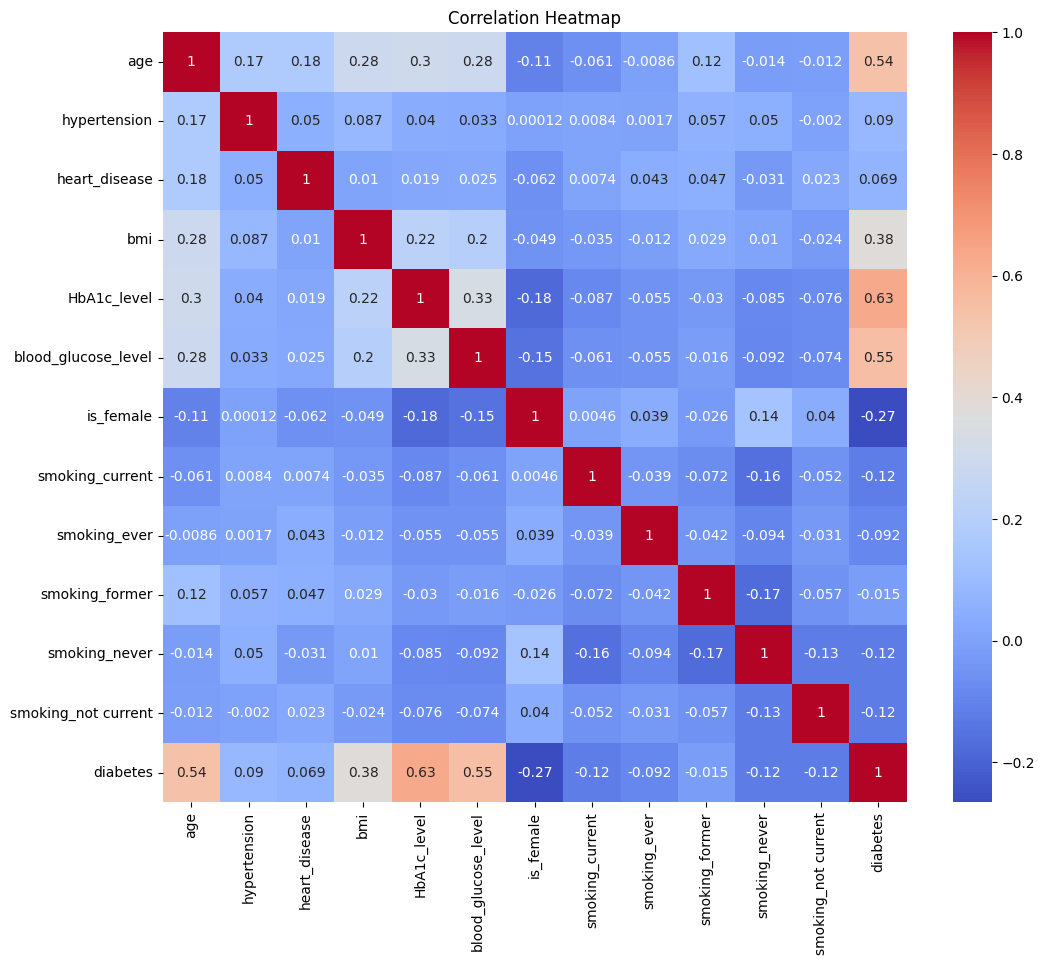

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(pd.concat([X_train_finall, y_train_finall], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scale features


In [17]:
scaler = StandardScaler()
X_train_sampled_scaled = scaler.fit_transform(X_train_sampled)
X_train_finall_scaled = scaler.transform(X_train_finall)
X_test_scaled = scaler.transform(X_test)

# GA implementation

In [51]:
# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the individual
def create_individual():
    return [random.randint(0, 1) for _ in range(X_train_finall_scaled.shape[1])]

# Define fitness function
def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]

    if not selected_features:
        return 0,

    X_train_finall_scaled_selected = X_train_finall_scaled[:, selected_features]
    X_test_scaled_selected = X_test_scaled[:, selected_features]

    # Train Decision Tree model with selected features
    dt_model = DecisionTreeClassifier(random_state=7)
    dt_model.fit(X_train_finall_scaled_selected, y_train_finall)

    y_pred = dt_model.predict(X_test_scaled_selected)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy,

# Initialize population
def create_population(pop_size):
    return [create_individual() for _ in range(pop_size)]

# Set up the genetic algorithm operations
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)  # Mutation (flip bit)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=20)

feature_names = X.columns.tolist()

# Define params for GA
generations = 10
cx_prob = 0.7
mut_prob = 0.2

# Run GA
for gen in range(generations):
    print(f"Generation {gen}")

    # Select best individuals for reproduction
    offspring = toolbox.select(population, len(population))

    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cx_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring:
        if random.random() < mut_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit

    # Replace old population with new one
    population[:] = offspring

    best_individual = tools.selBest(population, 1)[0]
    selected_feature_names = [feature_names[i] for i in range(len(best_individual)) if best_individual[i] == 1]

    print("Best individual:", best_individual)
    print(f"Selected Features: {selected_feature_names}")
    print("Best fitness:", best_individual.fitness.values[0])

# Extract the best solution (feature selection mask)
best_individual = tools.selBest(population, 1)[0]
selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

# Selected features
X_train_finall_scaled_selected = X_train_finall_scaled[:, selected_features]
X_test_scaled_selected = X_test_scaled[:, selected_features]

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0
Best individual: [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
Selected Features: ['hypertension', 'HbA1c_level', 'blood_glucose_level', 'smoking_never']
Best fitness: 0.96275
Generation 1
Best individual: [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
Selected Features: ['hypertension', 'HbA1c_level', 'blood_glucose_level', 'smoking_never']
Best fitness: 0.96275
Generation 2
Best individual: [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Selected Features: ['HbA1c_level', 'blood_glucose_level', 'smoking_ever', 'smoking_never']
Best fitness: 0.9664
Generation 3
Best individual: [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Selected Features: ['HbA1c_level', 'blood_glucose_level', 'smoking_ever', 'smoking_never']
Best fitness: 0.9664
Generation 4
Best individual: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
Selected Features: ['HbA1c_level', 'blood_glucose_level', 'smoking_never']
Best fitness: 0.9676
Generation 5
Best individual: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Selected Features: ['HbA1c_level', 'blood_glucose_le

In [48]:
final_model = DecisionTreeClassifier(random_state=7)
final_model.fit(X_train_finall_scaled_selected, y_train_finall)

DecisionTreeClassifier(random_state=7)

In [49]:
y_pred_ga = final_model.predict(X_test_scaled_selected)
print("\nFinal Model Performance with Selected Features:")
print(classification_report(y_test, y_pred_ga))
print("Accuracy:", accuracy_score(y_test, y_pred_ga))


Final Model Performance with Selected Features:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       1.00      0.67      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Accuracy: 0.97185


# Boosting implemention (with XGBoost)

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=7)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print("\nBagging with XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


Bagging with XGBoost Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       1.00      0.67      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Accuracy: 0.97195


# Bagging implemention (with SVM stimator)

In [ ]:
svm_model = SVC(C=10, kernel='linear', gamma='scale', random_state=7)

bagging_model = BaggingClassifier(estimator=svm_model, n_estimators=7, random_state=7, n_jobs=-1)

bagging_model.fit(X_train_finall_scaled, y_train_finall)

y_pred_bagging = bagging_model.predict(X_test_scaled)

In [ ]:
print("\nBagging with SVM Performance:")
print(classification_report(y_test, y_pred_bagging))
print("Accuracy:", accuracy_score(y_test, y_pred_bagging))


Bagging with SVM Performance:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     18300
           1       0.39      0.85      0.54      1700

    accuracy                           0.88     20000
   macro avg       0.69      0.86      0.73     20000
weighted avg       0.93      0.88      0.90     20000

Accuracy: 0.8763


# DT implemention

In [ ]:
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model = DecisionTreeClassifier(random_state=7)
dt_grid = GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train_finall_scaled, y_train_finall)

print("Best Parameters for Decision Tree:", dt_grid.best_params_)
print("Best Score for Decision Tree:", dt_grid.best_score_)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Score for Decision Tree: 0.9559999999999998


In [ ]:
best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test_scaled)

In [ ]:
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18300
           1       0.50      0.82      0.62      1700

    accuracy                           0.91     20000
   macro avg       0.74      0.87      0.79     20000
weighted avg       0.94      0.91      0.92     20000

Accuracy: 0.91405


# RF implemention

In [ ]:
rf_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=7)
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_finall_scaled, y_train_finall)

print("Best Parameters for Random Forest:", rf_grid.best_params_)
print("Best Score for Random Forest:", rf_grid.best_score_)

Best Parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for Random Forest: 0.9654


In [ ]:
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test_scaled)

In [ ]:
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.46      0.88      0.60      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.89      0.77     20000
weighted avg       0.94      0.90      0.91     20000

Accuracy: 0.90175


# TwinSVM implemention

In [ ]:
class TwinSVM():
    def __init__(self, learning_rate=0.001, lambda_parameter=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_parameter = lambda_parameter
        self.n_iters = n_iters


    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        rows, features = X.shape

        X_pos = self.X[self.Y == 1]
        X_neg = self.X[self.Y == 0]

        self.weights1 = np.zeros(features)
        self.bias1 = 0
        self.weights2 = np.zeros(features)
        self.bias2 = 0

        # First hyperplane for class 1
        for _ in range(self.n_iters):
            for x_pos in X_pos:
                distance = np.dot(x_pos, self.weights2) - self.bias2

                if distance >= -1:
                    dw1 = 2 * self.lambda_parameter * self.weights1 - x_pos
                    db1 = -1
                else:
                    dw1 = 2 * self.lambda_parameter * self.weights1
                    db1 = 0

                self.weights1 -= self.learning_rate * dw1
                self.bias1 -= self.learning_rate * db1

        # First hyperplane for class -1
        for _ in range(self.n_iters):
            for x_neg in X_neg:
                distance = np.dot(x_neg, self.weights1) - self.bias1

                if distance <= 1:
                    dw2 = 2 * self.lambda_parameter * self.weights2 - x_neg
                    db2 = -1
                else:
                    dw2 = 2 * self.lambda_parameter * self.weights2
                    db2 = 0

                self.weights2 -= self.learning_rate * dw2
                self.bias2 -= self.learning_rate * db2


    def predict(self, X):
        distance1 = abs(np.dot(X, self.weights1) - self.bias1)
        distance2 = abs(np.dot(X, self.weights2) - self.bias2)

        return np.where(distance1 < distance2, 1, 0)

In [ ]:
# Hyperparameters
param_grid_ts = {
    'learning_rate': [0.000001, 0.00001, 0.0001],
    'lambda_parameter': [0.000001, 0.00001, 0.0001],
    'n_iters': [250, 500, 1000]
}

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_sampled_scaled, y_train_sampled, test_size=0.2, random_state=7)

best_score_ts = -np.inf
best_params_ts = {}

for learning_rate in param_grid_ts['learning_rate']:
    for lambda_parameter in param_grid_ts['lambda_parameter']:
        for n_iters in param_grid_ts['n_iters']:
            tsvm = TwinSVM(learning_rate=learning_rate, lambda_parameter=lambda_parameter, n_iters=n_iters)
            tsvm.fit(X_train, y_train)

            y_pred = tsvm.predict(X_val)

            score = f1_score(y_val, y_pred)

            if score > best_score_ts:
                best_score_ts = score
                best_params_ts = {
                    'learning_rate': learning_rate,
                    'lambda_parameter': lambda_parameter,
                    'n_iters': n_iters
                }

# Train final model with best parameters for TwinSVM


In [ ]:
final_model_ts = TwinSVM(**best_params_ts)
final_model_ts.fit(X_train_finall_scaled, y_train_finall)

y_pred_ts = final_model_ts.predict(X_test_scaled)

In [ ]:
print("Best Parameters for TwinSVM:", best_params_ts)
print("Best Score for TwinSVM:", best_score_ts)

Best Parameters for TwinSVM: {'learning_rate': 1e-06, 'lambda_parameter': 1e-06, 'n_iters': 250}
Best Score for TwinSVM: 0.9090909090909091


# Evaluate dataset with TwinSVM

In [ ]:
print("\nTwinSVM Performance:")
print(classification_report(y_test, y_pred_ts))
print("Accuracy:", accuracy_score(y_test, y_pred_ts))


TwinSVM Performance:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     18300
           1       0.39      0.84      0.54      1700

    accuracy                           0.88     20000
   macro avg       0.69      0.86      0.73     20000
weighted avg       0.93      0.88      0.90     20000

Accuracy: 0.87605


# SVM implemention

In [ ]:
class SVM():
    def __init__(self, learning_rate = 0.001, lambda_parameter = 0.01, n_iters = 1000):
        self.learning_rate = learning_rate
        self.lambda_parameter = lambda_parameter
        self.n_iters = n_iters


    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        rows, features = X.shape
        self.weights = np.zeros(features)
        self.bias = 0
        y = np.where(self.Y == 0, -1, 1)
        for i in range(self.n_iters):
            for index, x in enumerate(self.X):
                condition = y[index] * (np.dot(x, self.weights) - self.bias) >= 1
                if condition:
                    dw = 2 * self.lambda_parameter * self.weights
                else:
                    dw = 2 * self.lambda_parameter * self.weights - (np.dot(y[index], x))
                    db = y[index]
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db


    def predict(self, X):
        results = np.dot(X, self.weights) - self.bias
        predictions = np.sign(results)
        y_hat = np.where(predictions <= -1, 0, 1)
        return y_hat

In [ ]:
# Hyperparameters
param_grid = {
    'learning_rate': [0.000001, 0.00001, 0.0001],
    'lambda_parameter': [0.000001, 0.00001, 0.0001],
    'n_iters': [250, 500, 1000]
}

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_sampled_scaled, y_train_sampled, test_size=0.2, random_state=7)

best_score = -np.inf
best_params = {}

for learning_rate in param_grid['learning_rate']:
    for lambda_parameter in param_grid['lambda_parameter']:
        for n_iters in param_grid['n_iters']:
            svm = SVM(learning_rate=learning_rate, lambda_parameter=lambda_parameter, n_iters=n_iters)
            svm.fit(X_train, y_train)

            y_pred = svm.predict(X_val)

            score = f1_score(y_val, y_pred)

            if score > best_score:
                best_score = score
                best_params = {
                    'learning_rate': learning_rate,
                    'lambda_parameter': lambda_parameter,
                    'n_iters': n_iters
                }

# Train final model with best parameters for SVM


In [ ]:
final_model = SVM(**best_params)
final_model.fit(X_train_finall_scaled, y_train_finall)

y_pred = final_model.predict(X_test_scaled)

In [ ]:
print("Best Parameters for SVM:", best_params)
print("Best Score for SVM:", best_score)

Best Parameters for SVM: {'learning_rate': 0.0001, 'lambda_parameter': 1e-06, 'n_iters': 250}
Best Score for SVM: 0.9166666666666666


# Evaluate dataset with SVM

In [ ]:
print("\nSVM Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


SVM Performance:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     18300
           1       0.39      0.86      0.53      1700

    accuracy                           0.87     20000
   macro avg       0.69      0.87      0.73     20000
weighted avg       0.93      0.87      0.89     20000

Accuracy: 0.87175


# SVM implemention (using libraries)

In [18]:
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

svm_model = SVC(random_state=7)

svm_grid = GridSearchCV(estimator=svm_model, param_grid=svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_finall_scaled, y_train_finall)

print("Best Parameters for SVM:", svm_grid.best_params_)
print("Best Score for SVM:", svm_grid.best_score_)

Best Parameters for SVM: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score for SVM: 0.9365


In [19]:
best_svm = svm_grid.best_estimator_

y_pred_svm = best_svm.predict(X_test_scaled)

In [20]:
print("\nSVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Performance:
              precision    recall  f1-score   support

           0       0.98      0.87      0.93     18300
           1       0.38      0.85      0.53      1700

    accuracy                           0.87     20000
   macro avg       0.68      0.86      0.73     20000
weighted avg       0.93      0.87      0.89     20000

Accuracy: 0.8709
